In [ ]:
%matplotlib inline

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
from os.path import normpath, basename
from skimage import io, transform
from PIL import Image

plt.ion()   # interactive mode

In [2]:
class TextureDataset(Dataset):

    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform
        path = os.path.dirname(os.path.dirname(self.root_dir))
        self.classes = os.listdir(path)

    def __len__(self):
        lista = os.listdir(self.root_dir)
        return len(lista)

    def __getitem__(self, idx):
        lista = os.listdir(self.root_dir)
        img_name = os.path.join(self.root_dir, lista[idx])
        image = io.imread(img_name)
        img = Image.fromarray(image)
        path = os.path.dirname(self.root_dir)
        label = basename(normpath(path))
        label = self.classes.index(label)

        if self.transform:
            img = self.transform(img)

        return (img, label)
    
    def classes(self):

        return self.classes

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

root = r'D:\Google Drive\UNICAMP\IC\KTH-TIPS\KTH-TIPS2-a'
classes = os.listdir(root)
data_dir = []
image_datasets = {'train': [] , 'val': []}

for i in range(len(classes)):
    data_dir.append(os.path.join(root,classes[i]))
    
subclasses = os.listdir(data_dir[0]) # Para que funcione, todas as classes devem ter o mesmo numero de subclasses

val_samp = 'sample_d'
train_samp = subclasses[:]
train_samp.remove(val_samp)
    
for i in range(len(classes)):
    image_datasets['val'].append(TextureDataset(os.path.join(data_dir[i], val_samp), data_transforms['val']))
    for j in range(len(train_samp)):
        image_datasets['train'].append(TextureDataset(os.path.join(data_dir[i], train_samp[j]), data_transforms['train']))

image_datasets = {x: torch.utils.data.ConcatDataset(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(image_datasets['train'].__getitem__(200))
print(image_datasets['val'].__getitem__(110))
print(image_datasets['train'].__len__())
print(image_datasets['val'].__len__())

(tensor([[[ 0.2111,  0.1939,  0.1597,  ...,  0.2796,  0.8447,  1.3927],
         [-0.0801, -0.0972, -0.1143,  ...,  0.5878,  0.7591,  0.9646],
         [-0.4911, -0.4739, -0.4226,  ...,  0.8789,  0.7933,  0.8104],
         ...,
         [ 0.7762,  0.7591,  0.7248,  ...,  0.2796,  0.4679,  0.5878],
         [ 0.7762,  0.7591,  0.7248,  ...,  0.5878,  0.7933,  0.8789],
         [ 0.7591,  0.7591,  0.7419,  ...,  0.8618,  1.0159,  1.0502]],

        [[ 0.3277,  0.2752,  0.2227,  ...,  0.3102,  0.8704,  1.4307],
         [-0.0399, -0.0574, -0.0924,  ...,  0.6779,  0.8179,  1.0280],
         [-0.4251, -0.4076, -0.3901,  ...,  1.0105,  0.9405,  0.9580],
         ...,
         [ 0.7829,  0.8004,  0.8179,  ...,  0.3452,  0.5378,  0.6604],
         [ 0.7829,  0.8004,  0.8179,  ...,  0.6604,  0.8704,  0.9580],
         [ 0.8179,  0.8179,  0.8179,  ...,  0.9230,  1.0980,  1.1331]],

        [[ 0.2348,  0.2348,  0.2522,  ...,  0.3742,  0.9145,  1.4722],
         [-0.0790, -0.0964, -0.1138,  ...,  

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



tensor([[[[ 1.4783,  1.6667,  0.9988,  ...,  0.7419,  1.2385,  1.9749],
          [ 1.5639,  1.7865,  1.4098,  ...,  0.8447,  0.9988,  1.3755],
          [ 1.9407,  2.0434,  1.7180,  ...,  0.6734,  0.8789,  1.3413],
          ...,
          [-0.5253, -0.4568, -0.2684,  ...,  2.0948,  1.4954,  0.3309],
          [-0.3541, -0.1143,  0.2111,  ...,  2.1462,  1.6495,  0.6563],
          [ 0.2453,  0.5536,  0.6221,  ...,  1.9749,  1.3584,  0.5878]],

         [[ 0.7304,  1.0630,  0.4328,  ..., -0.0224,  0.5728,  1.3256],
          [ 0.8880,  1.2381,  0.8880,  ...,  0.0476,  0.2927,  0.6779],
          [ 1.4307,  1.5532,  1.2381,  ..., -0.1099,  0.1877,  0.6779],
          ...,
          [-1.3880, -1.2129, -0.9853,  ...,  1.5357,  0.7129, -0.4776],
          [-1.1779, -0.7927, -0.4251,  ...,  1.7633,  0.8529, -0.1800],
          [-0.4601, -0.0224,  0.1001,  ...,  1.4132,  0.4503, -0.3375]],

         [[ 0.7054,  0.9319,  0.2696,  ..., -0.5670, -0.1487,  0.6008],
          [ 0.7402,  1.0888,  

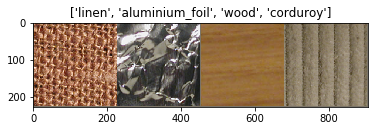

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#print (next((iter(dataloaders['train']))))
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
#inputs, classes = image_datasets['train'].__getitem__(200)

print (inputs)
print (classes)
print (class_names)
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])
#imshow(out)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 11)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8747 Acc: 0.7121
val Loss: 0.9222 Acc: 0.7232

Epoch 1/24
----------
train Loss: 0.4540 Acc: 0.8513
val Loss: 1.9822 Acc: 0.6188

Epoch 2/24
----------
train Loss: 0.3366 Acc: 0.8996
val Loss: 2.0034 Acc: 0.6456

Epoch 3/24
----------
train Loss: 0.3093 Acc: 0.9066
val Loss: 1.2026 Acc: 0.7079

Epoch 4/24
----------
train Loss: 0.2344 Acc: 0.9299
val Loss: 1.1422 Acc: 0.7079

Epoch 5/24
----------
train Loss: 0.2129 Acc: 0.9352
val Loss: 1.2383 Acc: 0.7414

Epoch 6/24
----------
train Loss: 0.1860 Acc: 0.9416
val Loss: 1.1977 Acc: 0.7328

Epoch 7/24
----------
train Loss: 0.1212 Acc: 0.9686
val Loss: 0.9061 Acc: 0.7701

Epoch 8/24
----------
train Loss: 0.1036 Acc: 0.9733
val Loss: 0.9552 Acc: 0.7682

Epoch 9/24
----------
train Loss: 0.0729 Acc: 0.9804
val Loss: 1.2935 Acc: 0.7261

Epoch 10/24
----------
train Loss: 0.0688 Acc: 0.9795
val Loss: 1.1497 Acc: 0.7634

Epoch 11/24
----------
train Loss: 0.0597 Acc: 0.9860
val Loss: 1.0360 Acc: 0.7874

Ep

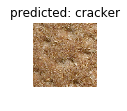

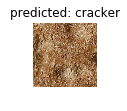

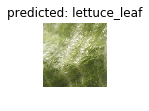

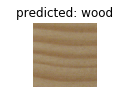

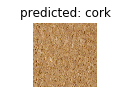

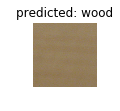

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 11)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0542 Acc: 0.6538
val Loss: 0.8556 Acc: 0.7184

Epoch 1/24
----------
train Loss: 0.6879 Acc: 0.7668
val Loss: 0.9223 Acc: 0.7107

Epoch 2/24
----------
train Loss: 0.6412 Acc: 0.7876
val Loss: 0.9076 Acc: 0.6906

Epoch 3/24
----------
train Loss: 0.5842 Acc: 0.8095
val Loss: 0.8438 Acc: 0.7165

Epoch 4/24
----------
train Loss: 0.6055 Acc: 0.8047
val Loss: 1.2130 Acc: 0.6916

Epoch 5/24
----------
train Loss: 0.5934 Acc: 0.8089
val Loss: 0.9425 Acc: 0.6954

Epoch 6/24
----------
train Loss: 0.5208 Acc: 0.8347
val Loss: 0.9949 Acc: 0.7165

Epoch 7/24
----------
train Loss: 0.4722 Acc: 0.8465
val Loss: 0.9208 Acc: 0.7174

Epoch 8/24
----------
train Loss: 0.4435 Acc: 0.8555
val Loss: 1.0439 Acc: 0.6897

Epoch 9/24
----------
train Loss: 0.4740 Acc: 0.8502
val Loss: 1.2418 Acc: 0.6619

Epoch 10/24
----------
train Loss: 0.4638 Acc: 0.8519
val Loss: 0.8816 Acc: 0.6916

Epoch 11/24
----------
train Loss: 0.4550 Acc: 0.8510
val Loss: 1.2158 Acc: 0.6791

Ep

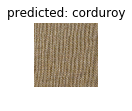

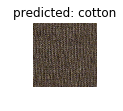

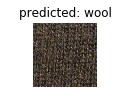

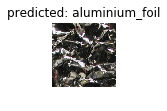

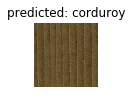

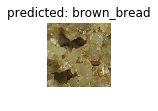

In [13]:
visualize_model(model_conv)

plt.ioff()
plt.show()